In [1]:
import pickle as pkl

import numpy as np

import matplotlib
matplotlib.rcParams.update({'font.size': 6})
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.gridspec as gridspec

from tqdm import tqdm
from glob import glob

from scipy.optimize import curve_fit

savefig = False

base_pathstem='/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/'
paper1_savepath = '/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/Paper1/plots/'

primary_incl = 30

In [2]:
# constants
from astropy.constants import e, c, m_e
import astropy.units as u
from scipy.special import gamma
e = e.esu.value * u.cm**1.5 * u.g**0.5 / u.s

#constants
e = e.cgs.value
c = c.cgs.value
m_e = m_e.cgs.value
#units
cm = 1.0
gram = 1.0
sec = 1.0
Hz = 1.0
kpc = (1.*u.kpc).cgs.value
Msun = (1.*u.Msun).cgs.value
erg = (1.*u.erg).cgs.value
def get_cgs (x): return x
def get_cgs_value (x): return x
    
# simulation units
# anchor points
simu_rho = get_cgs(10**(-15) * gram/cm**3)
simu_t = get_cgs(1.*sec)
simu_len = get_cgs(c*simu_t)
# derivative units
simu_mass = get_cgs(simu_rho * simu_len**3)
simu_en = simu_mass * get_cgs(c)**2 # erg
simu_press = simu_en / simu_len**3 # erg / cm^3
simu_B = np.sqrt(2.*simu_press) # sqrt( erg / cm^3 )
simu_B_8piCorr = np.sqrt(8.*np.pi*simu_press) # sqrt( erg / cm^3 )

In [3]:
sim2phys = {
    'Time':simu_t, # sec
    'x1f':simu_len, # cm
    'x2f':simu_len, # cm
    'x3f':simu_len, # cm
    'x1v':simu_len, # cm
    'x2v':simu_len, # cm
    'x3v':simu_len, # cm
    'rho':simu_mass/simu_len**3, # g / cm^3
    'press':simu_mass * (simu_len/simu_t)**2 / simu_len**3, # erg / cm^3
    'vel1': 1.0, # c
    'vel2': 1.0, # c
    'vel3': 1.0, # c
    'vel_tot': 1.0, # c
    'Bcc1': simu_B, # sqrt(erg / cm^3)
    'Bcc2': simu_B, # sqrt(erg / cm^3)
    'Bcc3': simu_B, # sqrt(erg / cm^3)
    'Bcc_tot': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_0': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_1': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_2': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_3': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_tot': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_tot_vsZ': simu_B, # sqrt(erg / cm^3)
    'enthalpy': simu_mass * (simu_len/simu_t)**2 / simu_mass, # erg/g
    'internal_energy': simu_mass * (simu_len/simu_t)**2 / simu_len**3, # erg / cm^3
    'internal_energy_vsZ': simu_mass * (simu_len/simu_t)**2 / simu_len**3, # erg / cm^3
    'j_nu': 1.0, # erg / cm**3
    'j_nu_vsZ': 1.0, # erg / cm**3
    'j_over_alpha_nu': 1.0, # erg / cm**2
    'j_over_alpha_nu_vsZ': 1.0, # erg / cm**2
    'flux_density': 1.0, # erg/(cm**2*sec) / cm**2
    'flux_density_vsZ': 1.0, # erg/(cm**2*sec) / cm**2
    'spectrum': (1.0, 1.0), # (Hz, erg / (s cm**2 Hz) / cm**2)
    'ddt_internal_energy': simu_mass * (simu_len/simu_t)**2 / simu_len**3 / simu_t, # erg / cm^3 / s
    'ddt_internal_energy_vsZ': simu_mass * (simu_len/simu_t)**2 / simu_len**3 / simu_t, # erg / cm^3 / s
}

In [4]:
out_dt_vtk = 0.1

In [5]:
# create a dictionary mapping corrugation amplitudes to shock aspect ratios
with open (f'/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/corrT2_press/prod1_corr_ampl/results_incl{primary_incl}/results_corr1ampl20/joined_vtk/IntSh2-p1.0073.vtk.pkl', 'rb') as f:
    data, _ = pkl.load(f)
    lam = 0.5*(np.max(data['x2v']) - np.min(data['x2v']))
    dx = data['x1v'][1] - data['x1v'][0]
    del data, _
ampl2ar = {}
ampl2ar_full = {}
for suite in ('corrT1_dens', 'corrT2_press'):
    with open(f'/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/{suite}/prod1_corr_ampl/results_incl{primary_incl}/shock_widths.pkl', 'rb') as f:
        amplitudes, widths = pkl.load(f)
    mask = np.where(np.array(widths) > 8)[0]
    ampls, ars = np.array(amplitudes)[mask], np.array(widths)[mask]*dx/lam
    ampl2ar[suite] = {ampl:ar for ampl,ar in zip(ampls, ars)}
    ampls, ars = np.array(amplitudes), np.array(widths)*dx/lam
    ampl2ar_full[suite] = {ampl:ar for ampl,ar in zip(ampls, ars)}
    del amplitudes, widths, mask, ars
    
# create an aspect-ratio colormap for curves
ar_min = np.min(tuple(np.min(tuple(ampl2ar[k].values())) for k in ampl2ar.keys()))
ar_max = np.max(tuple(np.max(tuple(ampl2ar[k].values())) for k in ampl2ar.keys()))
def ar_cmap (ar):
    return mplcm.rainbow((ar-ar_min)/(ar_max-ar_min))

In [6]:
def alignment_masks (times1, times2):
    '''Produces masks for two datasets
    where their times are aligned.'''
    return np.array([elem in times2 for elem in times1]), np.array([elem in times1 for elem in times2])

def mask_after_gap (times, dt):
    '''Produces a mask that turns off the first snapshot after a gap,
    as well as duplicate snapshots'''
    return np.array([True,] + [((e2 - e1 < 1.2*dt) and (e2 - e1 > 0.8*dt)) for e1,e2 in zip(times[:-1], times[1:])])

In [63]:
def broken_pl (x, xbr, p1, p2, A):
    return A / ( (xbr/x)**p1 + (xbr/x)**p2 )

class Dataset:
    
    def __init__ (
        self,
        name,
        label='',
        amplitudes=[1,2,5,10,20,50,75,100],
        shell_widths=[]
    ):
        self.name=name
        self.pathstem = base_pathstem + name + '/'
        if label == '':
            self.label=self.name
        else:
            self.label=label
        
        self.amplitudes=amplitudes
        self.n_ampl = len(self.amplitudes)
        self.colors = {self.amplitudes[i]:mplcm.jet(1.0*i/self.n_ampl) for i in range(self.n_ampl)}
        self.linestyles = {0:':', 1:'-'}
        
        self.shell_widths=shell_widths
        
    def plot_Fsyn_vs_time (self, ax, legend=False, legend_kwargs={}, ylabels=True, title=False, logscale=True):
        
        for ampl in self.amplitudes:
            for corr in [1,]:# [0,1]:
                with open(f'{self.pathstem}/prod1_corr_ampl/results_incl{primary_incl}/history_corr{corr}ampl{ampl}.pkl', 'rb') as f:
                    data = pkl.load(f)

                if corr == 0:
                    ax.plot(
                        data['times'] * sim2phys['Time'],
                        data['flux_density'] * sim2phys['flux_density'],
                        color=self.colors[ampl],
                        ls=self.linestyles[corr]
                    )
                else:
                    ax.plot(
                        data['times'] * sim2phys['Time'],
                        data['flux_density'] * sim2phys['flux_density'],
                        color=self.colors[ampl],
                        ls=self.linestyles[corr],
                        label=('$A=%.2f$' % (0.01*ampl,))
                    )

                del data
        if logscale: ax.set_yscale('log')
        if legend:
            ax.legend(**legend_kwargs)
        ax.set_ylim(3.0e-32, 9.0e-29)
        ax.set_xlabel('Time [s]')
        ax.grid(True)
        if ylabels:
            ax.set_ylabel('$dF_{\\rm syn}/dS$ [${\\rm erg}/({\\rm cm}^5{\\rm s})$]')
        else:
            ax.axes.yaxis.set_ticklabels([])
        if title:
            ax.set_title(self.label)
        
    def plot_FsynRelDiff_vs_ampl (self, ax, ylabels=True, logscale=False):
        '''Plot the integrated net synchrotron flux difference'''
        
        synchro_diff_tot = {}
        synchro_mean_tot = {}
        for ampl in self.amplitudes:
            data = {}
            for corr in [0,1]:
                with open(f'{self.pathstem}/prod1_corr_ampl/results_incl{primary_incl}/history_corr{corr}ampl{ampl}.pkl', 'rb') as f:
                    data[corr] = pkl.load(f)

            # align timestamps
            mask0, mask1 = alignment_masks(data[0]['times'], data[1]['times'])

            total_emission = 0.5 * (data[1]['flux_density'][mask1] + data[0]['flux_density'][mask0])
            total_emission = 0.5 * (total_emission[1:] + total_emission[:-1])

            difference = data[1]['flux_density'][mask1] - data[0]['flux_density'][mask0]
            difference = 0.5 * (difference[1:] + difference[:-1])

            dt = data[0]['times'][1] - data[0]['times'][0]

            synchro_diff_tot[ampl] = np.sum(difference*dt)
            synchro_mean_tot[ampl] = np.sum(total_emission*dt)

            del data

        # plot
        ax.plot(synchro_diff_tot.keys(), np.array(list(synchro_diff_tot.values())) / np.array(list(synchro_mean_tot.values())))
        ax.set_xlabel('Corr. Amplitude [%]')
        ax.ticklabel_format(axis='y', style='sci', scilimits=[0,0])
        if ylabels:
            ax.set_ylabel('$\\Delta F_{\\rm syn}/F_{\\rm syn}$')
        ax.set_yscale('log' if logscale else 'linear')
        
    def plot_FsynRelDiff_vs_ar (self, ax, ampl2ar_dict, ylabels=True, logscale=False, label='', linestyle='-'):
        '''Plot the integrated net synchrotron flux difference'''
        
        synchro_diff_tot = {}
        synchro_mean_tot = {}
        for ampl in self.amplitudes:
            if ampl not in ampl2ar_dict.keys(): continue
            data = {}
            for corr in [0,1]:
                with open(f'{self.pathstem}/prod1_corr_ampl/results_incl{primary_incl}/history_corr{corr}ampl{ampl}.pkl', 'rb') as f:
                    data[corr] = pkl.load(f)

            # align timestamps
            mask0, mask1 = alignment_masks(data[0]['times'], data[1]['times'])

            total_emission = 0.5 * (data[1]['flux_density'][mask1] + data[0]['flux_density'][mask0])
            total_emission = 0.5 * (total_emission[1:] + total_emission[:-1])

            difference = data[1]['flux_density'][mask1] - data[0]['flux_density'][mask0]
            difference = 0.5 * (difference[1:] + difference[:-1])

            dt = data[0]['times'][1] - data[0]['times'][0]

            synchro_diff_tot[ampl] = np.sum(difference*dt)
            synchro_mean_tot[ampl] = np.sum(total_emission*dt)

            del data

        # plot
        ax.plot(
            tuple(ampl2ar_dict[x] for x in synchro_diff_tot.keys()),
            np.array(list(synchro_diff_tot.values())) / np.array(list(synchro_mean_tot.values())),
            label=label,
            color='k',
            linestyle=linestyle
        )
        ax.scatter(
            tuple(ampl2ar_dict[x] for x in synchro_diff_tot.keys()),
            np.array(list(synchro_diff_tot.values())) / np.array(list(synchro_mean_tot.values())),
            color=tuple(self.colors[x] for x in synchro_diff_tot.keys())
        )
        # fit the slope
        
        # labels
        ax.set_xlabel('Corrugation aspect ratio')
#         ax.ticklabel_format(axis='y', style='sci', scilimits=[0,0])
        if ylabels:
            ax.set_ylabel('$\\Delta F_{\\rm syn}/F_{\\rm syn}$')
        ax.set_yscale('log' if logscale else 'linear')
        ax.set_xscale('log' if logscale else 'linear')
            
    def plot_FsynRelDiff_vs_time (self, ax, legend=False, legend_kwargs={}, xlabels=True, ylabels=True, ampl_subset=[], title=False):
        
        if not ampl_subset:
            ampl_subset = self.amplitudes
            colors = self.colors
        else:
            colors = {ampl_subset[i]:mplcm.jet(1.0*i/len(ampl_subset)) for i in range(len(ampl_subset))}
        
        for ampl in ampl_subset:
            data = {}
            for corr in [0,1]:
                with open(f'{self.pathstem}/prod1_corr_ampl/results_incl{primary_incl}/history_corr{corr}ampl{ampl}.pkl', 'rb') as f:
                    data[corr] = pkl.load(f)

            # align timestamps
            mask0, mask1 = alignment_masks(data[0]['times'], data[1]['times'])
            # calculate the difference and mean
            difference = data[1]['flux_density'][mask1] - data[0]['flux_density'][mask0]
            average = 0.5 * (data[1]['flux_density'][mask1] + data[0]['flux_density'][mask0])

            values = difference/average
            ax.plot(data[0]['times'][mask0], values, color=colors[ampl], ls=self.linestyles[corr], label=('$A=%.2f$' % (0.01*ampl)))
            #plt.scatter(data[0]['times'][mask0], values, color=colors[ampl], ls=linestyles[corr], label=('ampl = %i' % ampl), s=4)

            #mini, maxi = min(0., np.min(values)), np.max(values)
            #length = maxi - mini
            #mini, maxi = mini - 0.05*length, maxi + 0.05*length
            #diffscale[ampl] = [mini, maxi]

            del data

        if legend:
            ax.legend(**legend_kwargs)
        if xlabels:
            ax.set_xlabel('Time [s]')
        else:
            ax.axes.xaxis.set_ticklabels([])
        if ylabels:
            ax.set_ylabel('$\\Delta F_{\\rm syn}/F_{\\rm syn}$')
        if title:
            ax.text(0.025,0.85,self.label, transform=plt.gca().transAxes)
            
    def plot_polarization_diags (self,
             ax_fit=None, ax_slopes=None,
             amplitudes = (1,2,5,10,20,50,75,100)[:-2],
             ampl2ar_dict=ampl2ar,
             cmap=None
        ):
        
        if not cmap:
            colors = self.colors
        else:
            buff = (1,2,5,10,20,50,75,100)[:-2]
            colors = {buff[i]:cmap(min(0.9,1.0*i/(len(buff)-1))) for i in range(len(buff))}
        
        linestyles = {0:'--', 1:'-'}

        shock_width = {'corrT1_dens':0.2, 'corrT2_press':0.05} # in distance
        end_break = {'corrT1_dens':0.7, 'corrT2_press':0.7} # in distance

        slopes = {0:[], 1:[]}
        for ampl in tqdm(amplitudes):
            if ampl not in ampl2ar_dict[self.name].keys(): continue
            multiplier = (1+0.01*ampl) if self.name == 'corrT2_press' else 1.0
            for corr in (0,1):
                filename = sorted(glob(f'{self.pathstem}/prod1_corr_ampl/results_incl{primary_incl}/results_corr{corr}ampl{ampl}/joined_vtk/*.vtk.pkl'))[-1]
                with open(filename, 'rb') as f:
                    data = pkl.load(f)[0]

                x = data['x1v']
                y = np.mean(np.abs(data['Bcc2']), axis=0)

                xavg = 0.5*(x[1:]+x[:-1])
                dx = x[1:]-x[:-1]
                dy = y[1:]-y[:-1]

                # find the shocks
                ish = np.argmax(dy/dx), np.argmax(-dy/dx)

                # 2. collect the data, show as distance from the shock

                mid = np.int(len(x) / 2)
                left = y[ish[0]:mid]
                right = y[ish[1]:mid:-1]
                ll = np.int(end_break[self.name]*min(len(left), len(right)))
                start = np.int(shock_width[self.name] / dx[0])
                y = 0.5*(left[start:ll] + right[start:ll])
                x = np.arange(ll)[start:]*dx[0]

                # fit a broken power law
                pars, cov = curve_fit(
                    broken_pl, x, y,
                    p0=(1.0, 0, -1, 0.5),
                    sigma=x
                )
                errors = np.sqrt(np.diag(cov))

                # clean up
                del xavg, dx, dy, ish, mid, left, right, ll

                color = colors[ampl]
                kwargs = dict(
                    linestyle=linestyles[corr],
                    linewidth=0.5,
                    color=color
                )
                if corr == 1:
                    kwargs['label'] = f'A={0.01*ampl:.2f}'
                    
                if ax_fit:
                    ax_fit.plot(
                        x,y * multiplier, **kwargs
                    )
                    # overplot the fit
#                     ax_fit.plot(
#                         x,
#                         broken_pl(x, *pars) * multiplier,
#                         linestyle=':',
#                         linewidth=0.5,
#                         color=color
#                     )

                # save the fit for later plotting
                slopes[corr].append(
                    [ampl, *pars, *errors, *color]
                )

        if ax_fit:
            ax_fit.set_xscale('log')
            ax_fit.set_yscale('log')
            ax_fit.set_xlabel('$x-x_{\\rm sh}$ [lt-sec]')
            ax_fit.set_ylabel('$B_{\\perp}$' if self.name == 'corrT1_dens' else '$(1+0.01A) \\times B_{\\perp}$')
            if self.name == 'corrT1_dens':
                ax_fit.set_xlim(0.1,None)
            elif self.name == 'corrT2_press':
                ax_fit.legend(ncol=3, bbox_to_anchor=(0.2,2.68), loc='upper left')

        # plot the slopes
        if ax_slopes:
            for corr in range(2):
                sps = np.array(slopes[corr]).T
                colors = sps[-4:].T
                ars = [ampl2ar_dict[self.name][x] if x in ampl2ar_dict[self.name].keys() else None for x in sps[0]]
                ax_slopes.scatter(
                    ars, sps[2],
                    label=(None if not corr else '$p_1$'),
                    marker='o', s=4, facecolor=('w' if not corr else colors), edgecolor=colors, linewidth=0.5
                )
                ax_slopes.scatter(
                    ars, sps[3],
                    label=(None if not corr else '$p_2$'),
                    marker='^', s=4, facecolor=('w' if not corr else colors), edgecolor=colors, linewidth=0.5
                )
            if i == 0: plt.legend()
            ax_slopes.set_xlabel('Corrugation aspect ratio')
            ax_slopes.set_ylabel('Power law slope')
            ax_slopes.grid()
            ax_slopes.axhline(0., color='k', linewidth=0.5)
            
            ax_slopes.yaxis.set_label_position("right")
            ax_slopes.yaxis.tick_right()
            if self.name == 'corrT1_dens':
                ax_slopes.set_xlim(0.015, 0.185)
                ax_slopes.set_ylim(-2.5, 4)
            elif self.name == 'corrT2_press':
                ax_slopes.set_xlim(-0.01, 0.085)
                ax_slopes.set_ylim(-1, 0.15)

In [64]:
dataset_names = ['corrT1_dens', 'corrT2_press']#, 'corrT3_vel']
labels={
    'corrT1_dens':'Density corrugation',
    'corrT2_press':'Pressure corrugation',
    'corrT3_vel':'Velocity corrugation'
}
datasets = {name:Dataset(name, label=labels[name]) for name in dataset_names}

In [65]:
matplotlib.rcParams.update({'font.size': 6})
plt.figure(figsize=(3.5,3.5))
gs = gridspec.GridSpec(2,2, wspace=0.05, hspace=0.35)
for i, ds in enumerate(dataset_names):
    if ds == 'corrT1_dens':
        amplitudes = (1,2,5,10,20,50,75,100)[:-3]
    else:
        amplitudes = (1,2,5,10,20,50,75,100)[:-2]
    datasets[ds].plot_polarization_diags(
        plt.subplot(gs[i,0]), plt.subplot(gs[i,1]),
        amplitudes=amplitudes,
        ampl2ar_dict=ampl2ar_full,
        cmap=mplcm.nipy_spectral
    )
if True:
    plt.subplots_adjust(right=0.875, left=0.175, bottom=0.1)
    plt.savefig(paper1_savepath + 'polarization_diags.png', format='png', dpi=600)
else:
    plt.show()
plt.close()

  0%|          | 0/5 [00:00<?, ?it/s]/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
 20%|██        | 1/5 [00:01<00:05,  1.32s/it]/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
 40%|████      | 2/5 [00:02<00:03,  1.30s/it]/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
 60%|██████    

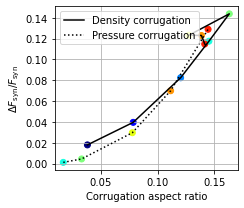

In [10]:
# Color coded Fsyn(t) as 3 panels for T1,2,3. In bottom panels show time-integrated relative Fsyn difference.

labels = {'corrT1_dens':'Density corrugation', 'corrT2_press':'Pressure corrugation'}
linestyles = {'corrT1_dens':'-', 'corrT2_press':':'}

fig = plt.figure(figsize=(3.5,3.))

for i in range(2):
    dataset = datasets[dataset_names[i]]
    
    # plot relative time-integrated synchrotron flux difference
    ax = plt.gca()
    plt.grid(True)
    dataset.plot_FsynRelDiff_vs_ar(ax,
        ylabels=(i==0),
        ampl2ar_dict=ampl2ar[dataset.name],
        label=labels[dataset.name],
        linestyle=linestyles[dataset.name]
    )
    plt.legend()

plt.tight_layout()
if savefig:
    #plt.subplots_adjust(top=0.88, right=0.98, left=0.15, bottom=0.075)
    plt.savefig(paper1_savepath + 'Fsyn_tot.png', format='png', dpi=600)
else:
    plt.show()
plt.close()

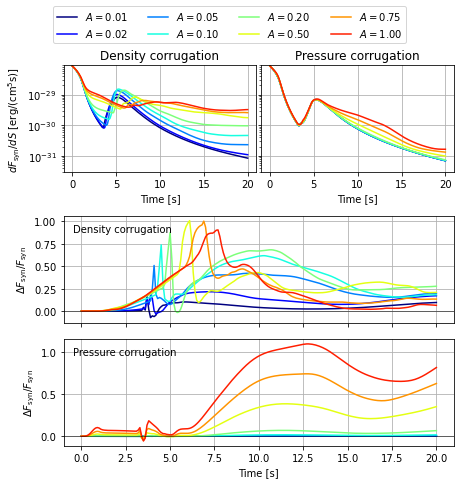

In [11]:
#####  Fsyn diff / ampl: try color-coded all in one plot, one panel for T1,2,3.

fig = plt.figure(figsize=(7.0,7.0))
gs = gridspec.GridSpec(4,2, height_ratios=(1,0.1,1,1), wspace=0.025)

for i in range(2):
    dataset = datasets[dataset_names[i]]
    
    # plot light curves
    ax = plt.subplot(gs[0,i])
    dataset.plot_Fsyn_vs_time(ax,
        legend=(i==0),
        legend_kwargs={
            'ncol':4, 'bbox_to_anchor':(1.8,1.6)
        },
        ylabels=(i==0),
        title=True
    )
    
    ax = plt.subplot(gs[i+2,:])
    dataset.plot_FsynRelDiff_vs_time(
        ax,
        legend=False,
        legend_kwargs={'ncol':2, 'loc':'upper right'},
        xlabels=(i==1),
        title=True
    )
    
    plt.grid()
    plt.axhline(0.,color='k', linewidth=0.5)
    
if savefig:
    plt.subplots_adjust(top=0.87, right=0.99, bottom=0.08, left=0.1)
    plt.savefig(paper1_savepath + 'Fsyn_relDiff.png', format='png', dpi=600)
else:
    plt.show()
plt.close()

In [12]:
# shock aspect ratio measurement figures

def plot_shock_single (filename_2d, margin, dvel_threshold, ax=None):
    
    from scipy import signal
    import pandas as pd

    # load the snapshot
    with open(filename_2d, 'rb') as f:
        data = pkl.load(f)[0]

    # basic properties
    dx = data['x1v'][1] - data['x1v'][0]
    middle = len(data['x1v']) // 2
    idx_margin = int(margin / dx)

    # find the shock front by local extrema of dvx/dx
    vel = data['vel1'][:,(middle-idx_margin):(middle+idx_margin)]
    dvel = signal.convolve2d(vel, [[-1,1]], mode='valid')
    xavg = 0.5*(data['x1v'][(middle-idx_margin+1):(middle+idx_margin)] + data['x1v'][(middle-idx_margin):(middle+idx_margin-1)])

    shock_y, shock_x = list(map(np.array, np.where(np.abs(dvel) > dvel_threshold)))
    df_shocks = pd.DataFrame(data=np.transpose((shock_y, shock_x)), columns=('shock_y', 'shock_x'))

    # limit shock_x to two values -- for the left and right shock
    shock_xl = df_shocks[df_shocks.shock_x < idx_margin].groupby('shock_y').mean()
    shock_xr = df_shocks[df_shocks.shock_x > idx_margin].groupby('shock_y').mean()
    shock_xlr = shock_xl.join(
        shock_xr,
        how='inner',
        lsuffix='l',
        rsuffix='r'
    )
    shock_y = shock_xlr.index

    # calculate the shock centroid
    shock_x = 0.5 * (shock_xlr.shock_xl + shock_xlr.shock_xr)

    # clean up
    del df_shocks, shock_xl, shock_xr

    # plot
    ax.contourf(data['x1v'], data['x2v'], data['rho'], 64, alpha=0.5)
    ax.scatter(
        [xavg[x] for x in shock_xlr.shock_xl.astype(int)],
        [data['x2v'][y] for y in shock_y.astype(int)],
        color='r', s=0.05
    )
    ax.scatter(
        [xavg[x] for x in shock_xlr.shock_xr.astype(int)],
        [data['x2v'][y] for y in shock_y.astype(int)],
        color='r', s=0.05
    )

    ax.scatter(
        [xavg[x] for x in shock_x.astype(int)],
        [data['x2v'][y] for y in shock_y.astype(int)],
        color='white', s=0.05
    )
    ax.set_xlim(-1.5,1.5)
    
    # labels
    ax.set_xlabel('x [lt-sec]')
    ax.set_ylabel('y [lt-sec]')
    
# plot

out_dt = 0.1

plt.figure(figsize=(3.5,3.5))
gs = plt.GridSpec(2,1)

plt.subplot(gs[0,0])
plot_shock_single(f'/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/corrT2_press/prod1_corr_ampl/results_incl{primary_incl}/results_corr1ampl20/joined_vtk/IntSh2-p1.0073.vtk.pkl', dvel_threshold=0.1, margin=4, ax=plt.gca())
plt.annotate(s='', xy=(0.1,-0.8), xytext=(0.1,2.2), arrowprops=dict(arrowstyle='<->'))
plt.text(0.11, 0.6, '$\lambda$')
plt.annotate(s='', xy=(-0.09,0.75), xytext=(0.12,0.75), arrowprops=dict(arrowstyle='->'))
plt.text(-0.07, 1.0, '$w$')

plt.subplot(gs[1,0])
with open(f'/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/corrT2_press/prod1_corr_ampl/results_incl{primary_incl}/shock_width_ampl20.pkl', 'rb') as f:
    frame, shock_width = pkl.load(f)
with open (f'/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/corrT2_press/prod1_corr_ampl/results_incl{primary_incl}/results_corr1ampl20/joined_vtk/IntSh2-p1.0073.vtk.pkl', 'rb') as f:
    data, _ = pkl.load(f)
    dx = data['x1v'][1] - data['x1v'][0]
    del data, _
time = (np.array(frame)-10.)*out_dt*simu_t
shock_width = np.array(shock_width)*dx
plt.plot(time, shock_width)
plt.xlabel('$t-t_{\\rm coll}$ [s]')
plt.ylabel('Shock width [lt-sec]')
plt.axvline(0., color='k', linestyle='--')
plt.axvline(time[np.argmax(shock_width)], color='r', linestyle='--')

plt.tight_layout()
if True:# savefig:
    #plt.subplots_adjust(top=0.99, right=0.99, bottom=0.12)
    plt.savefig(paper1_savepath + 'corrugation_ar_measurement.png', format='png', dpi=600)
else:
    plt.show()
plt.close()

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:75: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:77: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


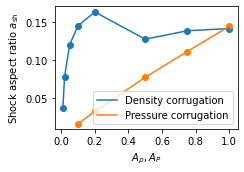

In [13]:
labels = {'corrT1_dens':'Density corrugation', 'corrT2_press':'Pressure corrugation'}
with open (f'/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/corrT2_press/prod1_corr_ampl/results_incl{primary_incl}/results_corr1ampl20/joined_vtk/IntSh2-p1.0073.vtk.pkl', 'rb') as f:
    data, _ = pkl.load(f)
    lam = 0.5*(np.max(data['x2v']) - np.min(data['x2v']))
    dx = data['x1v'][1] - data['x1v'][0]
    del data, _
    
plt.figure(figsize=(3.5,2.5))
for suite in ('corrT1_dens', 'corrT2_press'):
    with open(f'/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/{suite}/prod1_corr_ampl/results_incl{primary_incl}/shock_widths.pkl', 'rb') as f:
        amplitudes, widths = pkl.load(f)
    mask = np.where(np.array(widths) > 8)[0]
    plt.plot(0.01*np.array(amplitudes)[mask], np.array(widths)[mask]*dx/lam, label=labels[suite])
    plt.scatter(0.01*np.array(amplitudes)[mask], np.array(widths)[mask]*dx/lam)
plt.xlabel('$A_{\\rho},A_P$')
plt.ylabel('Shock aspect ratio $a_{\\rm sh}$')
plt.legend()

plt.tight_layout()

if savefig:
    plt.savefig(paper1_savepath + 'corrugation_ar_results.png', format='png', dpi=600)
else:
    plt.show()
plt.close()

In [14]:
linestyles = {30:'-', 60:'--'}

plt.figure(figsize=(3.5,3))

for incl in (30,60):

    with open(f'/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/corrT2_press/prod1_corr_ampl/results_incl{incl}/history_corr1ampl50.pkl', 'rb') as f:
        data2d = pkl.load(f)
    with open(f'/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/corrT2_press/prod1_corr_ampl/results_incl{incl}/history_corr0ampl50.pkl', 'rb') as f:
        data1d = pkl.load(f)

    # original: 1D and 2D runs calculated separately
    flux2d = data2d['flux_density']
    relDiff = 2 * (flux2d-data1d['flux_density']) / (flux2d+data1d['flux_density'])
    plt.plot(
        data2d['times'], relDiff,
        label='original ($\\vec{B}=\\vec{B}_{\\rm 2D}$)',
        linestyle=linestyles[incl]
    )

    # - with Bfield from a separate non-corrugated (1D) run
    alternative = 'B1d_sep'
    flux2d = np.array(data2d['alternatives'][alternative]['flux_density'])
    relDiff = 2 * (flux2d-data1d['flux_density']) / (flux2d+data1d['flux_density'])
    plt.plot(
        data2d['times'], relDiff,
        label='replaced ($\\vec{B}=\\vec{B}_{\\rm 1D}$)',
        linestyle=linestyles[incl]
    )

    # - with Bfield from the corrugated (2D) run scaled down so that the average matches the 1D case, leaving only the 2D structure (but not the overall bfield enhancement)
    alternative = 'B2d_scaled'
    flux2d = data2d['alternatives'][alternative]['flux_density']
    relDiff = 2 * (flux2d-data1d['flux_density']) / (flux2d+data1d['flux_density'])
    mask = np.where(relDiff < 0.2)[0]
    plt.plot(
        data2d['times'][mask], relDiff[mask],
        label='structure-only ($\\vec{B}=\\vec{B}_{\\rm 2D}B_{\\rm 1D}/B_{\\rm 2D, avg}$)',
        linestyle=linestyles[incl]
    )

# finalize plot
plt.legend(bbox_to_anchor=(-0.1,1.0), loc='lower left')
plt.axhline(0., color='k', linewidth=0.5)
plt.xlabel('Time [s]')
plt.ylabel('$\\Delta F_{\\rm syn}/F{\\rm syn}$')
plt.grid()

if savefig:
    plt.subplots_adjust(left=0.15, bottom=0.15, right=0.99, top=0.7)
    plt.savefig(paper1_savepath + 'FsynExp.png', format='png', dpi=600)
else:
    plt.show()
plt.close()

ValueError: operands could not be broadcast together with shapes (202,) (201,) 

In [ ]:
pathstem = f'/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/corrT1_dens/prod1_corr_ampl/results_incl{primary_incl}/results_corr1ampl20/joined_vtk'

snapshot_ids = (0, 21, 49, 85, 200)
n_levels = 64

cmaps = {'rho':'cubehelix', 'Bcc_fluid_tot':'inferno', 'flux_density':'afmhot'}

# save min and max values for the color scales
quantities = ('rho', 'Bcc_fluid_tot', 'flux_density')
vmins = {q:1e6 for q in quantities}
vmaxs = {q:-1e6 for q in quantities}
for i, snapshot_id in tqdm(enumerate(snapshot_ids[1:])):
    with open(f'{pathstem}/IntSh2-p1.{snapshot_id:04d}.vtk.pkl', 'rb') as f:
        data, _ = pkl.load(f)
    for quantity in quantities:
        data[quantity] = data[quantity].flatten()
        vmins[quantity] = min(vmins[quantity], np.min(data[quantity]))
        vmaxs[quantity] = max(
            vmaxs[quantity],
            np.percentile(
                data[quantity][np.where(data[quantity] > np.min(data[quantity]))[0]],
                99
            )
        )
    del data
    
# edit min/max values if needed
vmaxs['flux_density'] = 0.05 * vmaxs['flux_density']

plt.figure(figsize=(7,8))
gs = gridspec.GridSpec(len(snapshot_ids)+2, 3, hspace=0.05, wspace=0.05, height_ratios=(0.1,0.175,1,1,1,1,1))
for i, snapshot_id in tqdm(enumerate(snapshot_ids)):
    
    with open(f'{pathstem}/IntSh2-p1.{snapshot_id:04d}.vtk.pkl', 'rb') as f:
        data, _ = pkl.load(f)
        
    # apply vmin, vmax to have correct levels everywhere
    for quantity in quantities:
        data[quantity] = np.where(
            data[quantity] > vmins[quantity], data[quantity], vmins[quantity]
        )
        data[quantity] = np.where(
            data[quantity] < vmaxs[quantity], data[quantity], vmaxs[quantity]
        )
        
    plt.subplot(gs[i+2,0])
    plot = plt.contourf(
        data['x1v'], data['x2v'],
        data['rho'] * sim2phys['rho'],
        vmin=vmins['rho'] * sim2phys['rho'],
        vmax=vmaxs['rho'] * sim2phys['rho'],
        levels=n_levels,
        cmap=cmaps['rho']
    )
    plt.ylabel(f'$t={snapshot_id*out_dt_vtk:.1f}$s')
    if not i:
        plt.title('$\\rho_{\\rm fl}$ [ g $/$ cm$^3$ ]')
        plt.subplot(gs[0,0])
        cbar = plt.colorbar(plot, cax=plt.gca(), orientation='horizontal')
        cbar.set_ticks((0, 2e-14, 4e-14, 6e-14))
        plt.gca().xaxis.set_ticks_position('top')
        plt.locator_params(nbins=4)
        
    plt.subplot(gs[i+2,1])
    plot = plt.contourf(
        data['x1v'], data['x2v'],
        data['Bcc_fluid_tot'] * sim2phys['Bcc_fluid_tot'],
        vmin=vmins['Bcc_fluid_tot'] * sim2phys['Bcc_fluid_tot'],
        vmax=vmaxs['Bcc_fluid_tot'] * sim2phys['Bcc_fluid_tot'],
        levels=n_levels,
        cmap=cmaps['Bcc_fluid_tot']
    )
    if not i:
        plt.title('$B_{\\rm fl}$ [ $\\sqrt{{\\rm erg}/{\\rm cm}^3}$ ]')
        plt.subplot(gs[0,1])
        cbar = plt.colorbar(plot, cax=plt.gca(), orientation='horizontal')
        cbar.formatter.set_powerlimits((0, 0))
        cbar.set_ticks((0, 1e3, 2e3, 3e3))
        plt.gca().xaxis.set_ticks_position('top')
        plt.locator_params(nbins=4)
        
    plt.subplot(gs[i+2,2])
    plot = plt.contourf(
        data['x1v'], data['x2v'],
        data['flux_density'] * sim2phys['flux_density'],
        vmin=vmins['flux_density'] * sim2phys['flux_density'],
        vmax=vmaxs['flux_density'] * sim2phys['flux_density'],
        levels=n_levels,
        cmap=cmaps['flux_density']
    )
    if not i:
        plt.title('$dF_{\\rm syn}/dS$ [ erg $/$ (cm$^4$ s) ]')
        plt.subplot(gs[0,2])
        cbar = plt.colorbar(plot, cax=plt.gca(), orientation='horizontal')
        cbar.set_ticks((0, 0.4e-28, 0.8e-28, 1.2e-28))
        plt.gca().xaxis.set_ticks_position('top')
        plt.locator_params(nbins=4)
        
    del data
    
for i in range(len(snapshot_ids)):
    for j in range(3):
        plt.subplot(gs[i+2,j])
        plt.xlim(-12.5,12.5)
        if i+2 < len(snapshot_ids)-1:
            plt.gca().set_xticklabels([])
        else:
            plt.xlabel('$x$ [lt-sec]')
        plt.gca().yaxis.set_ticks_position('right')
        if j == 2:
            plt.ylabel('$y$ [lt-sec]')
            plt.gca().yaxis.set_label_position("right")
        else:
            plt.gca().set_yticklabels([])

if savefig:
    plt.subplots_adjust(left=0.04, right=0.93, bottom=0.06, top=0.94)
    plt.savefig(paper1_savepath + 'snapshots.png', format='png', dpi=600)
else:
    plt.show()
plt.close()